In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt #for plotting
from collections import Counter
from sklearn.metrics import confusion_matrix
import itertools
import seaborn as sns
import h5py
from subprocess import check_output
%matplotlib inline

#if not os.path.isdir('models'):
#    os.mkdir('models')

from google.colab import drive

drive.mount('/content/drive/')
project_path = '/content/drive/My Drive/Data/'

#Open the file as readonly
h5f = h5py.File(project_path + 'SVHN_single_grey1.h5', 'r')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# Load the training, test and validation set
X_train = h5f['X_train'][:]
y_train = h5f['y_train'][:]
X_test = h5f['X_test'][:]
y_test = h5f['y_test'][:]


h5f.keys()

#Close the file
#h5f.close()


<KeysViewHDF5 ['X_test', 'X_train', 'X_val', 'y_test', 'y_train', 'y_val']>

Print the shape of training and testing data

In [ ]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (42000, 32, 32)
y_train shape: (42000,)
X_test shape: (18000, 32, 32)
y_test shape: (18000,)


**Visualize the dataset**

Showing the first 100 test images, we have to build a model that would classify these images accurately.

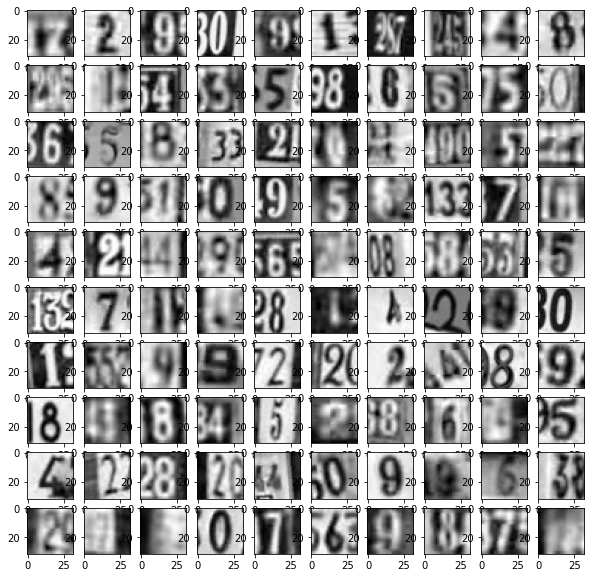

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize = (10,10))

rows = 10
columns = 10
w=10
h=10

for i in range(1,rows*columns+1) :
  img = X_test[i]
  fig.add_subplot(rows, columns, i)
  plt.imshow(img, cmap='gray')
plt.show()

In [ ]:
m_train=y_train.shape[0]
m_test=y_test.shape[0]
num_px=X_train.shape[1]
print("\033[1mNumber of training examples:m_train= "+ str(m_train))
print("Number of testing examples:m_test= "+ str(m_test))
print("Height/Width of each image:num_px= "+ str(num_px))
print("Each image is of size: (" + str(num_px)+","+str(num_px)+",3)")
print("train_set_x shape: "+ str (X_train.shape))
print("train_set_y shape: "+ str (y_train.shape))
print("test_set_x shape: "+ str (X_test.shape))
print("test_set_y shape: "+ str (y_test.shape))

Number of training examples:m_train= 42000
Number of testing examples:m_test= 18000
Height/Width of each image:num_px= 32
Each image is of size: (32,32,3)
train_set_x shape: (42000, 32, 32)
train_set_y shape: (42000,)
test_set_x shape: (18000, 32, 32)
test_set_y shape: (18000,)


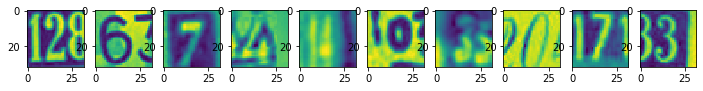

In [ ]:

%matplotlib inline
plt.figure(figsize=(12,10))
x,y=10,5
for i in range(10):
    plt.subplot(y,x,i+1)
    plt.imshow(X_train[i].reshape((32,32)),interpolation='nearest')
plt.show()

In [ ]:
# Reshape the images
X_train=X_train.reshape(len(X_train),32,32,1)
X_test=X_test.reshape(len(X_test),32,32,1)

In [ ]:

"""
Pixel values varies from 0 to 255.So normalized to get in range from 0 to 1 each image
"""
# Normalize the data
X_train = X_train/255.0
X_test = X_test/255.0

In [ ]:
#Feature Standardization
# It is used to center the data around zero mean and unit variance.
mean_px=X_train.mean().astype(np.float32)
std_px=X_train.std().astype(np.float32)
def standardize(x):
    return(x-mean_px)/std_px

In [ ]:

# One hot encoding labels
# One hot vector is a vector which is zero in maximum dimensions nd 1 in single dimension.For ex: 3 is [0,0,0,1,0,0,0,0]
from keras.utils.np_utils import to_categorical
y_train=to_categorical(y_train)
y_train.shape

(42000, 10)

In [ ]:
num_classes=y_train.shape[1]
num_classes

10

/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


([<matplotlib.axis.XTick at 0x7f77facfadd8>,
 <a list of 10 Text major ticklabel objects>)

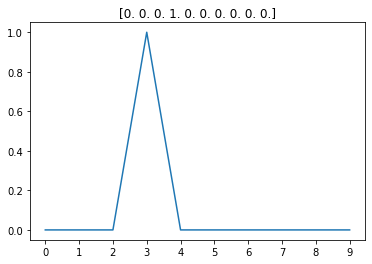

In [ ]:

plt.title(y_train[9])
plt.plot(y_train[9])
plt.xticks(range(10))

In [ ]:
# Designing Neural Network
# fit random seed for reproducibility 
seed=43
np.random.seed(seed)

In [ ]:

# linear Model
from keras.models import Sequential
from keras.layers import Lambda,Dense,Flatten,Dropout
from keras.callbacks import EarlyStopping
from keras.layers import BatchNormalization

Lambda layer performs simple arithmetic operations like sum, average, exponentiation etc.

In 1st layer of the model we have to define input dimensions of our data in (rows,columns,colour channel) format. (In theano colour channel comes first)

Flatten will transform input into 1D array. Dense is fully connected layer that means all neurons in previous layers will be connected to all neurons in fully connected layer. In the last layer we have to specify output dimensions/classes of the model. Here it's 10, since we have to output 10 different digit labels Flatten removes all dimensions and keep only one dimension .for example input(5,3) converted to input(15) after flatening

In [ ]:
model =Sequential()
model.add(Lambda(standardize,input_shape=(32,32,1)))
model.add(Flatten())
model.add(Dense(10,activation='softmax'))
print("input shape",model.input_shape)
print("output shape",model.output_shape)

input shape (None, 32, 32, 1)
output shape (None, 10)


**Compile network**

Before making network ready for training we have to make sure to add below things:

A loss function: to measure how good the network is

An optimizer: to update network as it sees more data and reduce loss value

Metrics: to monitor performance of network

In [ ]:
# compile network
# 1.A loss function
from keras.optimizers import RMSprop
model.compile(optimizer=RMSprop(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
from keras.preprocessing import image
gen = image.ImageDataGenerator()

**Cross Validation**

In [ ]:
from sklearn.model_selection import train_test_split
X = X_train
y = y_train
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.10, random_state=42)
batches = gen.flow(X_train, y_train, batch_size=64)
val_batches=gen.flow(X_val, y_val, batch_size=64)

In [ ]:
history=model.fit_generator(generator=batches, steps_per_epoch=batches.n, epochs=3, 
                    validation_data=val_batches, validation_steps=val_batches.n)

Epoch 1/3
   34/37800 [..............................] - ETA: 1:56 - loss: 2.3828 - accuracy: 0.1673

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


37800/37800 [==============================] - 2s 54us/step - loss: 2.3811 - accuracy: 0.1642 - val_loss: 2.4102 - val_accuracy: 0.1452


In [ ]:

history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:

history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

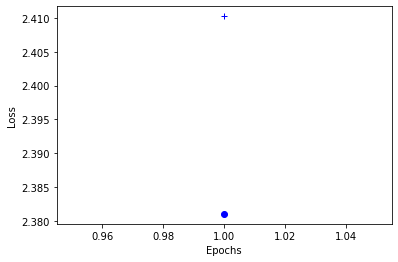

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss_values, 'bo')
# b+ is for "blue crosses"
plt.plot(epochs, val_loss_values, 'b+')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()

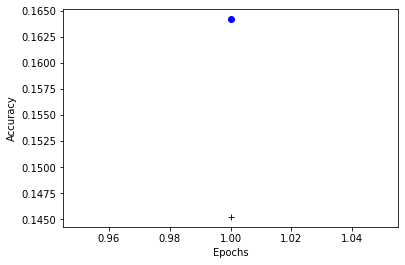

In [ ]:

plt.clf()   # clear figure
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']

plt.plot(epochs, acc_values, 'bo')
plt.plot(epochs, val_acc_values, 'b+')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.show()

**Fully Connected Layer **

In [ ]:
def get_fc_model():
    model = Sequential([
        Lambda(standardize, input_shape=(32,32,1)),
        Flatten(),
        Dense(512, activation='relu'),
        Dense(10, activation='softmax')
        ])
    model.compile(optimizer='Adam', loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [ ]:
fc = get_fc_model()
fc.optimizer.learrning_rate=0.01

In [ ]:
history=fc.fit_generator(generator=batches, steps_per_epoch=batches.n, epochs=3, 
                    validation_data=val_batches, validation_steps=val_batches.n)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/3
37800/37800 [==============================] - 5s 122us/step - loss: 1.3851 - accuracy: 0.5753 - val_loss: 1.0369 - val_accuracy: 0.6933


**Convolutional Neural Network**

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
batch_size = 64
epochs = 20
input_shape = (32, 32, 1)

In [ ]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',kernel_initializer='he_normal',input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',kernel_initializer='he_normal'))
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.20))
model.add(Conv2D(64, (3, 3), activation='relu',padding='same',kernel_initializer='he_normal'))
model.add(Conv2D(64, (3, 3), activation='relu',padding='same',kernel_initializer='he_normal'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), activation='relu',padding='same',kernel_initializer='he_normal'))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.RMSprop(),
              metrics=['accuracy'])

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.0001)

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=15, # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 30, 30, 32)        320       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)         

In [ ]:
datagen.fit(X_train)
h = model.fit_generator(datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,y_val),
                              verbose = 1, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction],)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
590/590 [==============================] - 170s 285ms/step - loss: 2.1456 - accuracy: 0.2424 - val_loss: 0.6932 - val_accuracy: 0.8212
Epoch 2/20
590/590 [==============================] - 168s 284ms/step - loss: 0.8900 - accuracy: 0.7115 - val_loss: 0.3832 - val_accuracy: 0.8883
Epoch 3/20
590/590 [==============================] - 168s 285ms/step - loss: 0.6528 - accuracy: 0.7933 - val_loss: 0.3266 - val_accuracy: 0.8990
Epoch 4/20
590/590 [==============================] - 167s 283ms/step - loss: 0.5573 - accuracy: 0.8249 - val_loss: 0.2884 - val_accuracy: 0.9190
Epoch 5/20
590/590 [==============================] - 168s 285ms/step - loss: 0.4784 - accuracy: 0.8511 - val_loss: 0.3022 - val_accuracy: 0.9174
Epoch 6/20
590/590 [==============================] - 168s 285ms/step - loss: 0.4421 - accuracy: 0.8609 - val_loss: 0.2570 - val_accuracy: 0.9271
Epoch 7/20
590/590 [==============================] - 169s 286ms/step - loss: 0.4189 - accuracy: 0.8695 - val_loss: 0.2462 -

In [ ]:
final_loss, final_acc = model.evaluate(X_val, y_val, verbose=0)
print("Final loss: {0:.6f}, final accuracy: {1:.6f}".format(final_loss, final_acc))

Final loss: 0.202044, final accuracy: 0.942143


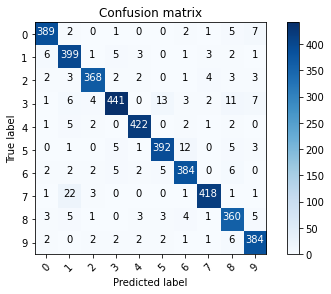

In [ ]:
# Look at confusion matrix 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred, axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_val, axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10))


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


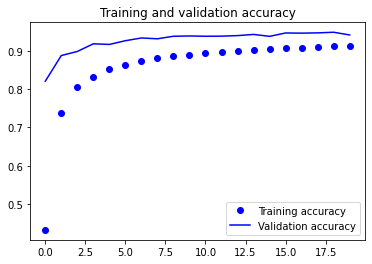

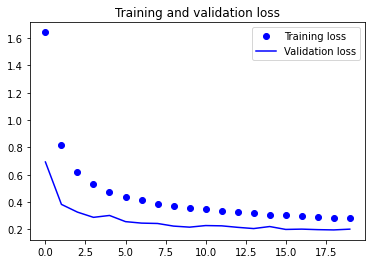

In [ ]:
print(h.history.keys())
accuracy = h.history['accuracy']
val_accuracy = h.history['val_accuracy']
loss = h.history['loss']
val_loss = h.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

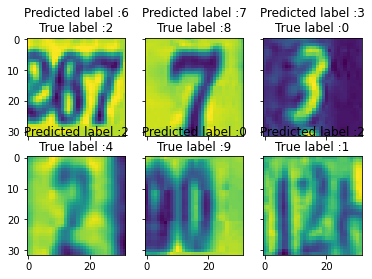

In [ ]:
# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((32,32)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

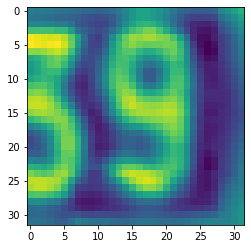

In [ ]:
test_im = X_train[154]
plt.imshow(test_im.reshape(32,32), cmap='viridis', interpolation='none')

Let's see the activation of the 2nd channel of the first layer:

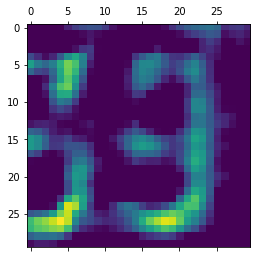

In [ ]:
from keras import models
layer_outputs = [layer.output for layer in model.layers[:8]]
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(test_im.reshape(1,32,32,1))

first_layer_activation = activations[0]
plt.matshow(first_layer_activation[0, :, :, 4], cmap='viridis')

In [ ]:
model.layers[:-1]# Droping The Last Dense Layer

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


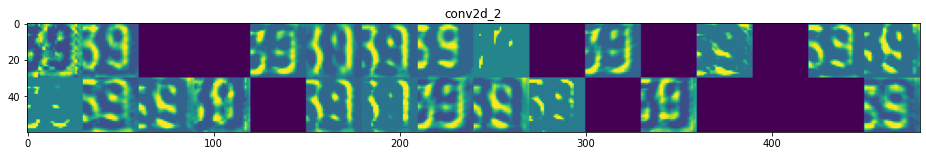

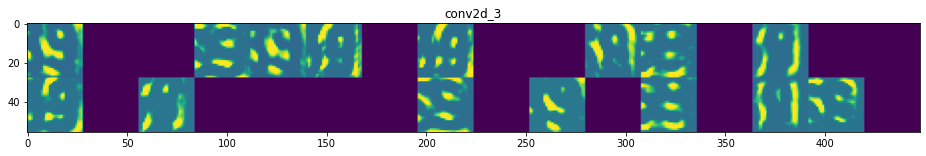

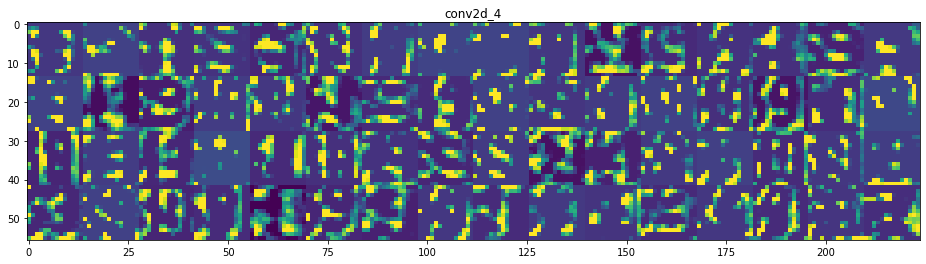

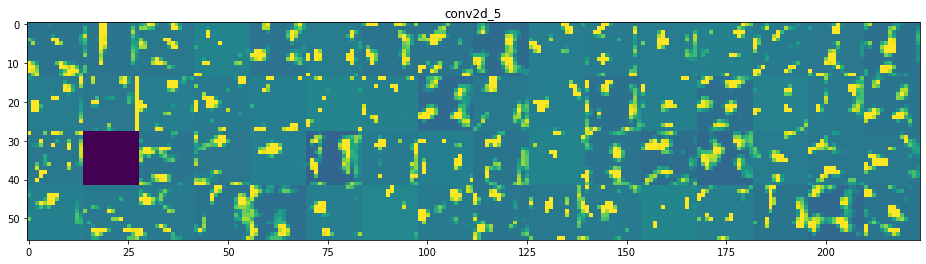

In [ ]:
layer_names = []
for layer in model.layers[:-1]:
    layer_names.append(layer.name) 
images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations):
    if layer_name.startswith('conv'):
        n_features = layer_activation.shape[-1]
        size = layer_activation.shape[1]
        n_cols = n_features // images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))
        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[0,:, :, col * images_per_row + row]
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size : (col + 1) * size,
                             row * size : (row + 1) * size] = channel_image
        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1],
                            scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


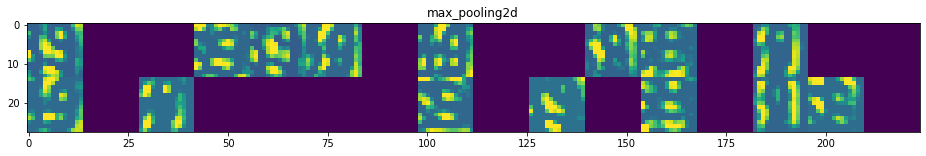

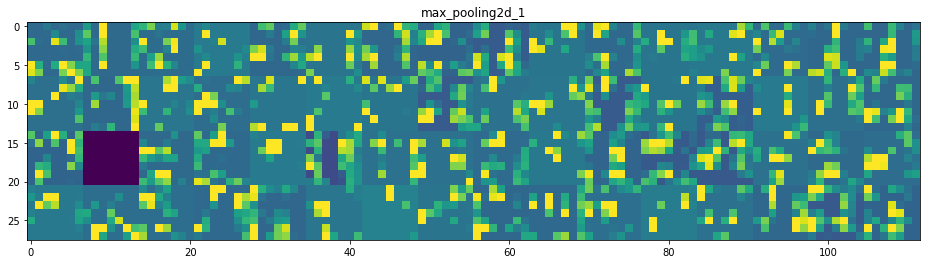

In [ ]:
layer_names = []
for layer in model.layers[:-1]:
    layer_names.append(layer.name) 
images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations):
    if layer_name.startswith('max'):
        n_features = layer_activation.shape[-1]
        size = layer_activation.shape[1]
        n_cols = n_features // images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))
        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[0,:, :, col * images_per_row + row]
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size : (col + 1) * size,
                             row * size : (row + 1) * size] = channel_image
        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1],
                            scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


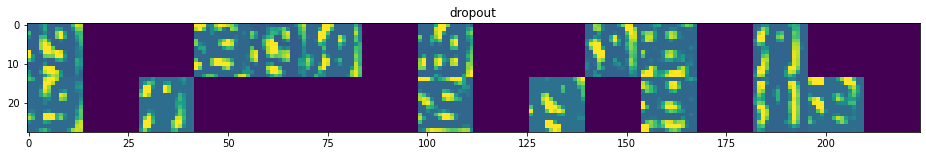

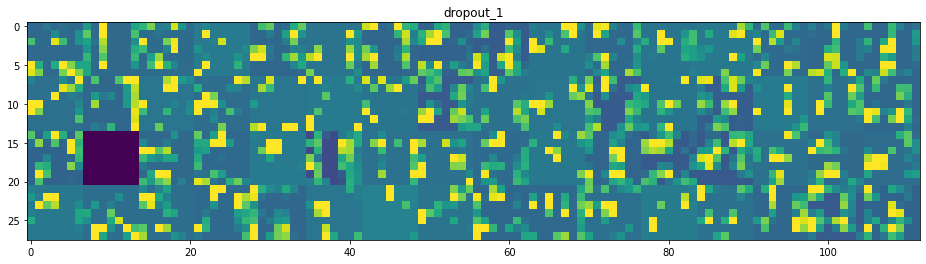

In [ ]:

layer_names = []
for layer in model.layers[:-1]:
    layer_names.append(layer.name) 
images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations):
    if layer_name.startswith('drop'):
        n_features = layer_activation.shape[-1]
        size = layer_activation.shape[1]
        n_cols = n_features // images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))
        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[0,:, :, col * images_per_row + row]
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size : (col + 1) * size,
                             row * size : (row + 1) * size] = channel_image
        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1],
                            scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')

**Classifcation Report**

In [ ]:
# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred, axis = 1)
Y_true_classes = np.argmax(y_val, axis = 1)

In [ ]:
Y_pred_classes[:5], Y_true_classes[:5]

(array([5, 7, 9, 5, 1]), array([5, 7, 9, 5, 7]))

In [ ]:

from sklearn.metrics import classification_report
target_names = ["Class {}".format(i) for i in range(num_classes)]
print(classification_report(Y_true_classes, Y_pred_classes, target_names=target_names))

              precision    recall  f1-score   support

     Class 0       0.96      0.96      0.96       407
     Class 1       0.90      0.95      0.92       421
     Class 2       0.96      0.95      0.95       388
     Class 3       0.96      0.90      0.93       488
     Class 4       0.97      0.97      0.97       435
     Class 5       0.94      0.94      0.94       419
     Class 6       0.93      0.94      0.94       408
     Class 7       0.97      0.94      0.95       447
     Class 8       0.90      0.94      0.92       385
     Class 9       0.93      0.96      0.94       402

    accuracy                           0.94      4200
   macro avg       0.94      0.94      0.94      4200
weighted avg       0.94      0.94      0.94      4200



In [ ]:
predicted_classes = model.predict_classes(X_test)
submissions=pd.DataFrame({"ImageId": list(range(1,len(predicted_classes)+1)),
                         "Label": predicted_classes})
submissions.to_csv("SVHNPred.csv", index=False, header=True)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
model.save('SVHNModelSubmission.h5')
json_string = model.to_json()